In [1]:
"""

Code taken from DiCE paper: https://arxiv.org/abs/1802.05098
All the creadit goes to the authors.

"""


import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.misc
import os
import csv
import itertools
import tensorflow.contrib.slim as slim
import numpy as np
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns

%matplotlib inline

/Users/mateuszochal/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/mateuszochal/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import numpy as np


class IPD():
    """
    A two-agent vectorized environment.
    Possible actions for each agent are (C)ooperate and (D)efect.
    """
    # Possible actions
    NUM_AGENTS = 2
    NUM_ACTIONS = 2
    NUM_STATES = 5

    def __init__(self, max_steps, batch_size=1):
        self.max_steps = max_steps
        self.batch_size = batch_size
        self.payout_mat = np.array([[-1., 0.], [-3., -2.]])
        self.available_actions = [
            np.ones((batch_size, self.NUM_ACTIONS), dtype=int)
            for _ in range(self.NUM_AGENTS)
        ]

        self.step_count = None

    def reset(self):
        self.step_count = 0
        init_state = np.zeros((self.batch_size, self.NUM_STATES))
        init_state[:, -1] = 1
        observations = [init_state, init_state]
        info = [{'available_actions': aa} for aa in self.available_actions]
        return observations, info

    def step(self, action):
        ac0, ac1 = action

        self.step_count += 1

        rewards = []
        state0 = np.zeros((self.batch_size, self.NUM_STATES))
        state1 = np.zeros((self.batch_size, self.NUM_STATES))
        for i, (a0, a1) in enumerate(zip(ac0, ac1)):
            rewards.append([self.payout_mat[a1][a0], self.payout_mat[a0][a1]])
            state0[i, a0 * 2 + a1] = 1
            state1[i, a1 * 2 + a0] = 1
        rewards = list(map(np.asarray, zip(*rewards)))
        observations = [state0, state1]

        done = (self.step_count == self.max_steps)
        info = [{'available_actions': aa} for aa in self.available_actions]

        return observations, rewards, done, info

In [6]:
tf.reset_default_graph()

def get_mat(game):
    if game == 'p': 
        payout_mat_1 = np.array([[-1,0],[-3,-2]])
        payout_mat_2= payout_mat_1.T
    else:
        payout_mat_1 = np.array([[1,-1],[-1,1]])
        payout_mat_2 = -1*payout_mat_1
    gamma = 0.96
    return payout_mat_1, payout_mat_2, gamma

gamma = tf.placeholder(shape=[],dtype=tf.float32)

# Helper functions
def build_policy(scope, env, theta, max_steps, reuse=None):
    pi = {}
    with tf.variable_scope(scope, reuse=reuse):
        # Placeholders
        pi['acs_ph'] = tf.placeholder(shape=[None, None], dtype=tf.int32)
        pi['obs_ph'] = tf.placeholder(shape=[None, None, env.NUM_STATES], dtype=tf.float32)
        pi['rews_ph'] = tf.placeholder(shape=[None, None], dtype=tf.float32)
        pi['target'] = tf.placeholder(shape=[None, None], dtype=tf.float32)
        pi['discount_vec'] = tf.placeholder(shape=[None, 1, 1], dtype=tf.float32)

        # Parameters
        pi['theta'] = theta
        pi['theta_val'] = tf.Variable(tf.random_normal([env.NUM_STATES]))
        pi['theta_val_target'] = tf.Variable(tf.random_normal([env.NUM_STATES]))

        # Log probs and predictions
        logits = tf.reduce_sum(
            tf.multiply(pi['obs_ph'], tf.reshape(pi['theta'], shape=(1, 1, -1))),
            axis=-1, keep_dims=True)
        logits = tf.concat([logits, tf.zeros_like(logits)], -1)
        
        pi['value'] = tf.reduce_sum(
            tf.multiply(pi['obs_ph'], tf.reshape(pi['theta_val'], shape=(1, 1, -1))),
            axis=-1, keep_dims=True)
        
        pi['value_target'] = tf.reduce_sum(
            tf.multiply(pi['obs_ph'], tf.reshape(pi['theta_val'], shape=(1, 1, -1))),
            axis=-1, keep_dims=True)
        
        pi['log_pi'] = tf.nn.log_softmax(logits)
        pi['acs_onehot'] = tf.one_hot(
            pi['acs_ph'], env.NUM_ACTIONS, dtype=tf.float32)
        pi['log_pi_acs'] = tf.reduce_sum(
            tf.multiply(pi['log_pi'], pi['acs_onehot']),
            axis=-1)
        pi['pi'] = tf.nn.softmax(logits)
        pi['pi_acs'] = tf.reduce_sum(
            tf.multiply(pi['pi'], pi['acs_onehot']),
            axis=-1)

        ac_logp0_cumsum = [tf.reshape(pi['log_pi_acs'][0], [1, -1]) ]
        for i in range(1,max_steps):
            ac_logp0_cumsum.append(tf.add(ac_logp0_cumsum[-1], pi['log_pi_acs'][ i]))
        pi['log_pi_acs_cumsum'] = tf.concat(ac_logp0_cumsum,0)
        
        pi['predict'] = tf.squeeze(tf.multinomial(
            tf.reshape(pi['log_pi'], shape=(-1, env.NUM_ACTIONS)), 1))
        
        pi['loss_value'] = tf.reduce_mean(tf.reduce_sum(tf.pow(tf.squeeze(pi['value'])  - pi['target'], 2),axis=0))     
    return pi

def magic_box(x):
    return tf.exp(x - tf.stop_gradient(x))


def get_naive_hessian_pi_squared(policies):
    losses = [ tf.reduce_mean(tf.reduce_sum(tf.multiply(pi['pi_acs'] / tf.stop_gradient(pi['pi_acs']), pi['rews_ph'] )),axis=0) for pi in policies]
    return losses


def gradient(x, theta):
    return tf.gradients(x, theta)[0]
    
def get_dice_objective(scope, policies):
    dependencies = magic_box( sum( pi['log_pi_acs_cumsum'] for pi in policies) )
    baseline = 1-magic_box( sum( pi['log_pi_acs'] for pi in policies) )
    losses = [
        tf.reduce_mean(tf.reduce_sum(tf.multiply(pi['rews_ph'], dependencies),axis=0)) +
        tf.reduce_mean(tf.reduce_sum(tf.multiply(tf.squeeze( tf.stop_gradient(tf.multiply(pi['value'], pi['discount_vec']))), baseline),axis=0))
        for pi in policies
    ]
    return losses


def get_actor(pi, sess):
    def actor(ob):
        ac = sess.run(pi['predict'], feed_dict={pi['obs_ph']: [ob]})
        return ac
    return actor



def Vs(theta_1_all_5_dim, theta_2_all_5_dim, R_1, R_2):
    theta_1 = tf.slice(theta_1_all_5_dim, [0,0], [4,1] )
    theta_2 = tf.slice(theta_2_all_5_dim, [0,0], [4,1] )

    theta_1_0 = tf.slice(theta_1_all_5_dim, [4,0], [1,1] )
    theta_2_0 = tf.slice(theta_2_all_5_dim, [4,0], [1,1] )

    p_1 = tf.nn.sigmoid(theta_1)
    p_2 = tf.nn.sigmoid(theta_2)

    p_1_all = tf.nn.sigmoid(theta_1_all_5_dim)
    p_2_all = tf.nn.sigmoid(theta_2_all_5_dim)

    p_1_0 = tf.nn.sigmoid(theta_1_0)
    p_2_0 = tf.nn.sigmoid(theta_2_0)

    p_1_0_v = tf.concat([p_1_0, (1-p_1_0)], 0)
    p_2_0_v = tf.concat([p_2_0, (1-p_2_0)], 0)

    s_0 = tf.reshape(tf.matmul(p_1_0_v, tf.transpose(p_2_0_v)),[-1,1])

    P = tf.concat([tf.multiply(p_1,p_2), tf.multiply(p_1,(1-p_2)),tf.multiply(1-p_1,(p_2)), tf.multiply(1-p_1,(1-p_2))],1)
    
    I_m_P = tf.diag([1.0,1.0,1.0,1.0]) - P*gamma
    v_1 = tf.matmul(tf.matmul(tf.matrix_inverse( I_m_P),R_1), s_0,transpose_a=True)
    v_2 = tf.matmul(tf.matmul(tf.matrix_inverse( I_m_P),R_2), s_0,transpose_a=True)
    return [v_1, v_2, p_1_all, p_2_all]

#Placeholder for the flattened version of the payout matrix
R_1 = tf.placeholder(shape=[4,1],dtype=tf.float32)
R_2 = tf.placeholder(shape=[4,1],dtype=tf.float32)

In [7]:
# Experiment parameters
n_agents = 2
batch_size = 128
batch_size_large = 100000
max_steps=100
gamma_val = .96
train_episodes = 400

env = IPD(max_steps=max_steps, batch_size=batch_size)
env_large = IPD(max_steps=max_steps, batch_size=batch_size_large)

theta_all = tf.Variable(tf.random_normal([2 * env.NUM_STATES]))
theta_1 = theta_all[:5]
theta_2 = theta_all[5:]

thetas = [theta_1, theta_2]

thetas_all = [theta_all, theta_all]

policies = [build_policy("pi_%d" % (i + 1), env, theta, max_steps) for i, theta in enumerate(thetas)]
v_1_p, v_2_p = get_dice_objective("delta", policies)

[v_1, v_2, p_1_all, p_2_all] = Vs(tf.reshape(theta_1, [-1,1]), 
                                   tf.reshape(theta_2, [-1,1]), R_1, R_2)

optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.005)

loss = sum( [ pi['loss_value'] for pi in policies ])
train = optimizer.minimize(loss)

assign_target = [ pi['theta_val_target'].assign( pi['theta_val']) for pi in policies ]

grad_p = [ gradient(v, theta) for v, theta in zip([v_1_p, v_2_p], thetas_all)]


grad_exact = [ gradient(v, theta) for v, theta in zip([v_1, v_2], thetas_all)]

#get approximate and exact hessians
h_ps = [tf.hessians(v, theta_all) for  v in [v_1_p, v_2_p]]
h_exacts = [tf.hessians(v, theta_all) for  v in [v_1, v_2]]

def get_feed_dict(obs, acs, rews, target, disc_count):
    feed_dict = dict(sum([
        [(pi['obs_ph'], obs[i]), (pi['acs_ph'], acs[i]), (pi['rews_ph'], rews[i]), (pi['target'], target[i]), (pi['discount_vec'],disc_count)]
        for i, pi in enumerate(policies)
    ], []))
    return feed_dict

init = tf.global_variables_initializer()

In [7]:
payout_mat_1, payout_mat_2, gamma_val =  get_mat('p')
disc_count = gamma_val**(np.array(range(max_steps))).reshape([-1, 1, 1])

r1  = np.reshape(payout_mat_2,[-1,1])
r2  = np.reshape(payout_mat_1,[-1,1])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(assign_target)
    actors = [get_actor(pi, sess) for pi in policies]
    for e in range(train_episodes):
        if e == train_episodes - 1:
            env = env_large
        obs, acs, rets, rews = [], [], [], []
        
        t = 0
        ob, info = env.reset()
        done = False
        gamma_t = 1.
        gamma_list = np.zeros(max_steps)
        while not done:
            obs.append(ob)
            ac = [a(o) for a, o in zip(actors, ob)]
            ob, rew, done, _ = env.step(ac)
            ob[1] = ob[0]
            acs.append(ac)
            rets.append([r * gamma_t for r in rew])
            rews.append(rew)
            gamma_list[t]=gamma_t
            gamma_t *= gamma_val
            t += 1
        obs = list(map(np.asarray, zip(*obs)))
        acs = list(map(np.asarray, zip(*acs)))
        rets = list(map(np.asarray, zip(*rets)))2
        rews = list(map(np.asarray, zip(*rews)))
        final_return = [sess.run(pi['value_target'], {pi['obs_ph']: [o]}) for pi, o in zip(policies, ob)]
        #Cummulative return logic
        for ret, final in zip(rets, final_return):
            ret[-1] += gamma_t*final[0,:,0]

        target = [np.copy(rew) for rew in rews]
        cum_rew =  [final[0,:,0] for final in final_return]
        for t_p in range(t)[::-1]:
            cum_rew = [ c_rew*gamma_val + r_ex[t_p] for c_rew, r_ex in zip(cum_rew, rews)]
            for i in range(env.NUM_AGENTS):
                target[i][t_p] = np.copy(cum_rew[i])
                
        approx_feed = get_feed_dict(obs, acs, rets, target, disc_count)
        feed_dict = { R_1:r1, R_2: r2, gamma: gamma_val }    
        v1p, v2p, _, l = sess.run([v_1_p, v_2_p, train, loss ], approx_feed)
        v1, v2 = sess.run( [v_1, v_2], feed_dict)
        if e % 40 == 0:
            sess.run(assign_target)
            print('loss', l)
        v1p, v2p, hp, gradp = sess.run([v_1_p, v_2_p, h_ps, grad_p ], approx_feed)
        v1, v2, hexact, gradexact = sess.run( [v_1, v_2, h_exacts, grad_exact], feed_dict)


('loss', 201192.8)
('loss', 5469.522)
('loss', 4560.5176)
('loss', 4224.953)
('loss', 4354.584)
('loss', 4014.4866)
('loss', 4708.2393)
('loss', 3957.7756)
('loss', 3966.955)
('loss', 4049.1064)


In [5]:
print("Sampled per step Returns:", [v1p*(1-gamma_val ), v2p*(1-gamma_val)])
print("Exact per step Returns:", [v1[0][0]*(1-gamma_val), v2[0][0]*(1-gamma_val)])

#Plot gradients
for i in range(2):
    plt.plot( gradp[i], gradexact[i], 'o')
    print('corr ', str(i), np.corrcoef( gradp[i], gradexact[i])[1,0])

NameError: name 'v1p' is not defined

('corr ', 0.9839973957119282)
('corr ', 0.9742641710986226)


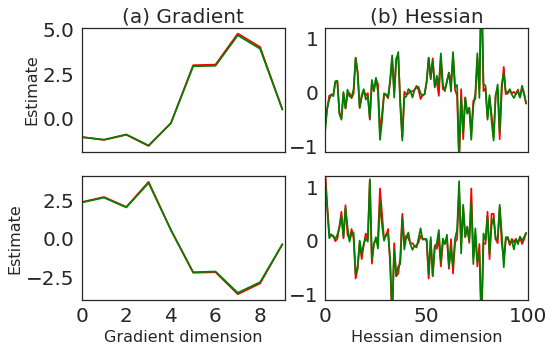

In [10]:
import seaborn
sns.set_style("white", {'axes.grid': False, 'grid.color': '.9', 'grid.linestyle': u'--'}) 
matplotlib.rc('axes', titlesize=20, labelsize=16) 
matplotlib.rc('legend', fontsize=18) 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
matplotlib.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})#Plot hessian values

fig = plt.figure(figsize = (8,5))

for value in [0,1]:
    ax = plt.subplot(2,2,2*value+2)
    plt.plot(  hexact[value][0].reshape([-1]),'r')
    plt.plot(  hp[value][0].reshape([-1]),'g')
    if value == 0:
        ax.get_xaxis().set_visible(False)
        ax.set_title("(b) Hessian")
    print('corr ', np.corrcoef( hexact[value][0].reshape([-1]),hp[value][0].reshape([-1]) )[1,0])
    plt.ylim([-1.1, 1.2])
    plt.xlim([0, 100])
    plt.xlabel('Hessian dimension')

    
for value in [0,1]:
    ax = plt.subplot(2,2,2*value+1)
    plt.plot(  gradexact[value].reshape([-1]),'r')
    plt.plot(  gradp[value].reshape([-1]),'g')
    if value == 0:
        ax.get_xaxis().set_visible(False)
        ax.set_title("(a) Gradient")
    plt.xlim([0, 9.1])
    plt.ylabel('Estimate')
    plt.xlabel('Gradient dimension')
    plt.xticks([0,2,4,6, 8])
